In [1]:
import pickle
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load all data

G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_all_nodes_merged.pkl', 'rb'))
ALL_RELS, ALL_RAW = pickle.load(open('data/title+1s_all_merged.pkl', 'rb'))
ART_VELO = pickle.load(open('/home/muheng/Debunk_cache_data/article_velocity.pkl', 'rb'))
all_nodes_df = pickle.load(open('data/cache/all_nodes_df.pkl', 'rb'))

In [3]:
#data to plot

lifespan = [ART_VELO[item]['life'] for item in ART_VELO]
halflife = [ART_VELO[item]['mid'] for item in ART_VELO]
lifespan = [np.log10(item + 1e-6) for item in lifespan]
halflife = [np.log10(item + 1e-6) for item in halflife]

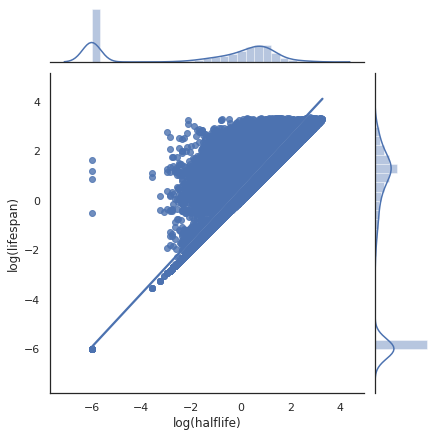

In [4]:
#plot 

sns.set(style="white", color_codes=True)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

g = sns.jointplot(x=halflife,y=lifespan, kind="reg")

g.set_axis_labels('log(halflife)', 'log(lifespan)')

### The lifespan vs. halflife for articles
Many of the articles are having 0 for both halflife/lifespan, indicating they only got 1 share on the social media.

If we take those articles out:

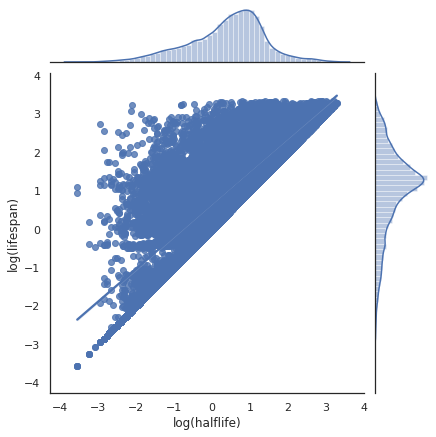

In [16]:
#data to plot

lifespan = []
halflife = []
for aid in ART_VELO:
    if ART_VELO[aid]['life'] == 0 or ART_VELO[aid]['mid'] == 0:
        continue
    else:
        lifespan.append(ART_VELO[aid]['life'])
        halflife.append(ART_VELO[aid]['mid'])

corr_coef = np.corrcoef(lifespan, halflife)[0][1]
        
lifespan = [np.log10(item + 1e-6) for item in lifespan]
halflife = [np.log10(item + 1e-6) for item in halflife]

g = sns.jointplot(x=halflife,y=lifespan, kind="reg")

g.set_axis_labels('log(halflife)', 'log(lifespan)')

In [17]:
#correlation stats

tau, p = scipy.stats.kendalltau(lifespan, halflife)

print(f'N = {len(lifespan)},corr-coef = {corr_coef:.3f}, tau = {tau:.3f}, p for tau = {p:.3f}')

N = 39156,corr-coef = 0.522, tau = 0.554, p for tau = 0.000


As we can see that there are week correlation between halflife/lifespan with pearson correlation coefficient = 0.522 for N = 39156. The ranking correlation coefficient is a bit higher than the pearson correlation.

# What are users' responses look like? How to categorize them?

In [7]:
#query database

import pymysql.cursors
mydb = pymysql.connect(host="localhost",
                    user="muheng",
                    passwd="password",
                    database="NSF_Debunking",
                    charset="utf8mb4",
                    cursorclass=pymysql.cursors.DictCursor)
cursor = mydb.cursor()

query = """
    SELECT t.text, ta.article_id 
    FROM TWEETS as t, TWEET_URL as ta
    WHERE t.tweet_id = ta.tweet_id
"""

cursor.execute(query)
res = cursor.fetchall()

In [8]:
#prepare preferred data structure

aid2article = {}
for idx in ALL_RAW:
    aid = ALL_RAW[idx]['article_id']
    aid2article[aid] = ALL_RAW[idx]

aid2responses = {}
for item in res:
    aid = item['article_id']
    tweet = item['text']
    if aid not in aid2responses:
        aid2responses[aid] = []
    aid2responses[aid].append(tweet)
sorted_aid2responses = sorted(aid2responses.items(), key=lambda x:len(x[1]), reverse=True)

In [9]:
#trying to process the response tweets

top = 3

rem_tweets = sorted_aid2responses[top][1]
title = aid2article[sorted_aid2responses[top][0]]['title']

url_title = aid2article[sorted_aid2responses[top][0]]['article_url'].split('/')[-1].split('.')[0].replace('-', ' ').replace('_', ' ')

after_rem = []

for tweet in rem_tweets:
    
    tweet = tweet.lower()
    tweet = tweet.replace(title.lower(), '<<TITLE>>')
    tweet = tweet.replace(url_title.lower(), '<<URL_TITLE>>')
    tokens = tweet.split()
    
    _rem_tokens = []
    for token in tokens:
        if token.startswith('https://') or token.startswith('http://'):
            continue
        if token.startswith('@'):
            token = '<<MENTION>>'
            
        if token == 'rt':
            token = '<<RT>>'
            
        _rem_tokens.append(token)
        
    after_rem.append(' '.join(_rem_tokens))

In [10]:
title

'Did coronavirus originate in Chinese government laboratory?'

In [11]:
url_title

'Did coronavirus originate Chinese government laboratory'

In [12]:
after_rem[:5]

['<<TITLE>> | daily mail online',
 'oooooh but here were the crazy conspiracy theorists for speculating that this was true!',
 '<<RT>> <<MENTION>> oooooh but here were the crazy conspiracy theorists for speculating that this was true!',
 '<<RT>> <<MENTION>> oooooh but here were the crazy conspiracy theorists for speculating that this was true!',
 '<<RT>> <<MENTION>> oooooh but here were the crazy conspiracy theorists for speculating that this was true!']

In [13]:
rem_tweets[:5]

['Did coronavirus originate in Chinese government laboratory? | Daily Mail Online https://t.co/46nAXlsxFv',
 'Oooooh but here were the crazy conspiracy theorists for speculating that this was true!\n\n https://t.co/odc2CHydP9',
 'RT @Jordan_Sather_: Oooooh but here were the crazy conspiracy theorists for speculating that this was true!\n\n https://t.co/odc2CHydP9',
 'RT @Jordan_Sather_: Oooooh but here were the crazy conspiracy theorists for speculating that this was true!\n\n https://t.co/odc2CHydP9',
 'RT @Jordan_Sather_: Oooooh but here were the crazy conspiracy theorists for speculating that this was true!\n\n https://t.co/odc2CHydP9']

## How to categorize the responses to an article?

- **unconditional sharing**: sharing the article without publishing comments. This includes tweets that only has the title/part of the article in the text.

- **repeated comments**: some highly repeated contents through all shares. The repeated contents are usually from the url text/part of the article. **retweeting others'comments** is also considered as repeated comments.

- **metadata**: including #mentions, #hashtags, "has title", "has repeated comments"

- **linguistic cues**: from the text other than the repeated contents and titles, extract the linguistic features

- **information source cues**: the source where the information is from, e.g. "daily mail online". However I haven't find out a good way of identifying these cues

## orthoganality of rumors?